# Iterative fitting on Buckingham potential

In [1]:
# Load in the relevant packages

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
import matplotlib.pyplot as plt
import json
from ase.io import read

from ccs_fit.ase_calculator.buck import Buck
with open("CCS_params_reference.json", "r") as f:
    CCS_params_ref = json.load(f)
calc = CCS(CCS_params=CCS_params_ref)

Fit_on_forces=False  #Enable/disable option for fitting CCS potential to atomic forces. 

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [2]:
TiO2 = read('TiO2.poscar')
TiO2 = TiO2 * [4,4,6]

TiO2.calc = calc

orig_cell = TiO2.get_cell()
orig_struc = TiO2.copy()

displacement_magnitude=0.03
disp_steps=5
rounds=5

trainset_list="file_list" # List of strucutres to include in the database (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.95, 1.05, 6):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i, seed=counter)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            print(nrg)
            xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
            write(xyz_file,rattle_struc)
            print(xyz_file,file=f)
            counter += 1

f.close()

/home/thism292/anaconda3/envs/CCS_fiterative/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


8543.983900030871
8542.568839655572
9214.547495923325
8875.98546779078
10129.280985257185
5600.999755541849
5636.576235189189
5871.259728834417
5900.197355809587
6178.984317770381
4368.461843897309
4397.215998134108
4496.320683367927
4694.553352637534
4890.953141724345
3787.3464772517314
3819.8558419600827
3892.0929959360337
4071.143351904195
4276.3902453768505
3518.9439997794375
3548.612304933414
3613.6223826607084
3789.89651977228
4069.088688613752
3405.091435169861
3436.196558463347
3502.3238656173403
3672.367691407162
3854.8298764514266
8543.983900030871
8433.53792563895
8639.657897591733
9010.293442198163
10278.608193590215
5600.999755541849
5638.38509898656
5738.452228621427
5942.064588904559
6528.126569778602
4368.461843897309
4396.768211586047
4508.270427543008
4686.604446559331
4927.0344429740335
3787.3464772517314
3818.5278776284113
3891.081938016311
4076.8641649680217
4358.566425440061
3518.9439997794375
3544.9709818473707
3622.5460629658746
3721.5472471329713
4023.761063685

In [3]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="TiO2.db",file_list="file_list",overwrite=True)

    Building data-bases: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 96.73it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``LJ.db`` since the reference energies and forces are obtained from a Lennard Jones potential.

In [4]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="TiO2.db",include_forces=Fit_on_forces)

    Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:32<00:00,  4.55it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key. A more comprehensive guide on the fitting options can be found in Advanced_Tutorials/Search_Mode.


In [5]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "O-Ti": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [6]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['O', 'Ti']
    Applying monotonic constraints for pair:  O-O
    Applying monotonic constraints for pair:  O-Ti
    Merging intervals for pair O-O; number of intervals reduced from 105 to 103. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Ti


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [00:03<00:00, 29.55it/s]


    The best switch is (17, 114) with rmse: 0.005424665888328976, corresponding to distances of [1.7  6.05] Å for element pairs ['O-O', 'O-Ti'].


In [7]:
from shutil import copyfile
copyfile("CCS_params.json", "CCS_params_pre_prune.json")

'CCS_params_pre_prune.json'

### Make CaTiO3 database

In [8]:
CaTiO3 = read('CaTiO3.poscar')
CaTiO3 = CaTiO3 * [4, 4, 3]

CaTiO3.calc = calc

orig_cell = CaTiO3.get_cell()
orig_struc = CaTiO3.copy()

displacement_magnitude=0.03
disp_steps=5
rounds=5

trainset_list="file_list" # List of strucutres to include in the database (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.95, 1.05, 6):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i, seed=counter)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            print(nrg)
            xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
            write(xyz_file,rattle_struc)
            print(xyz_file,file=f)
            counter += 1

f.close()

/home/thism292/anaconda3/envs/CCS_fiterative/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


12546.360738273594
12808.91038099444
12802.789764662579
12881.920442574916
14161.763788187955
7296.989226458699
7373.403840008252
7581.666610930285
7894.171439335281
8187.7241252015465
5395.985794315111
5436.513125053763
5556.075333865607
5812.027220236784
6115.882835940606
4636.169235668235
4663.3741353023415
4793.857250313465
4967.351575885579
5212.87809995717
4289.755223656647
4334.646046697029
4431.46898756453
4591.522911073281
4864.215818887845
4126.122953834948
4164.797260960545
4289.275951071471
4431.272246860271
4613.170164423337
12546.360738273594
12405.542910914497
12596.616031699008
13932.80450800562
13080.888635394678
7296.989226458699
7331.563835427802
7454.333729609996
7842.887068530492
8230.551153568998
5395.985794315111
5434.679922799185
5559.514646857272
5792.066503941056
6087.621327653008
4636.169235668235
4671.56392975176
4793.3778168533845
4999.037364598759
5314.372013334236
4289.755223656647
4325.887483826418
4406.4740173756
4628.414880189393
4870.227578506521
4126

In [9]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="CaTiO3.db",file_list="file_list",overwrite=True)

    Building data-bases: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 89.80it/s]


In [10]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="CaTiO3.db",include_forces=False)

    Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [01:24<00:00,  1.78it/s]


### Pruning

In [2]:
!ccs_prune -d CaTiO3.db


--------------------------------------------------------------------------------
  0%|                                                   | 0/150 [00:00<?, ?it/s]/home/thism292/anaconda3/envs/CCS_fiterative/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
    Fetching data: 100%|██████████████████████| 150/150 [01:28<00:00,  1.70it/s]


In [3]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "DFTB",
        "merging"  : "True"
    },
    "Twobody": {
                "Ca-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [4]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Ca', 'O', 'Ti']
    Applying monotonic constraints for pair:  Ca-O
    Applying monotonic constraints for pair:  O-O
    Merging intervals for pair Ca-O; number of intervals reduced from 106 to 104. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Ti


    Finding optimum switch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:03<00:00, 28.07it/s]


    The best switch is (104, 30) with rmse: 0.1028153685010174, corresponding to distances of [5.99 2.73] Å for element pairs ['Ca-O', 'O-O'].


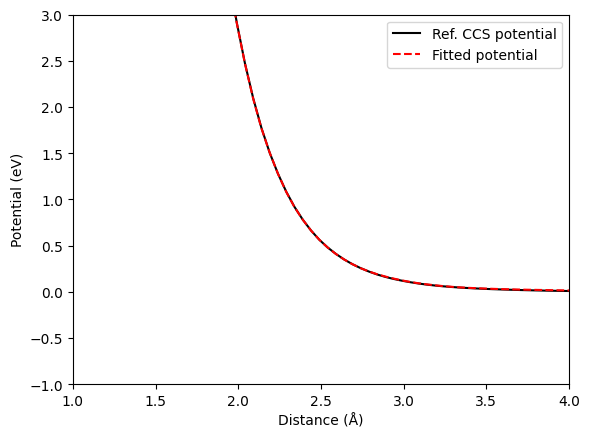

In [6]:
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params_reference.json", "r") as f:
    CCS_params_ref = json.load(f)

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

r_ref = np.array(CCS_params_ref["Two_body"]["Ca-O"]["r"])
e_ref = CCS_params_ref["Two_body"]["Ca-O"]["spl_a"]

r = np.array(CCS_params["Two_body"]["Ca-O"]["r"])
e = CCS_params["Two_body"]["Ca-O"]["spl_a"]

plt.xlim(1.,4)
plt.ylim(-1,3)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r_ref,e_ref,color='black',label="Ref. CCS potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

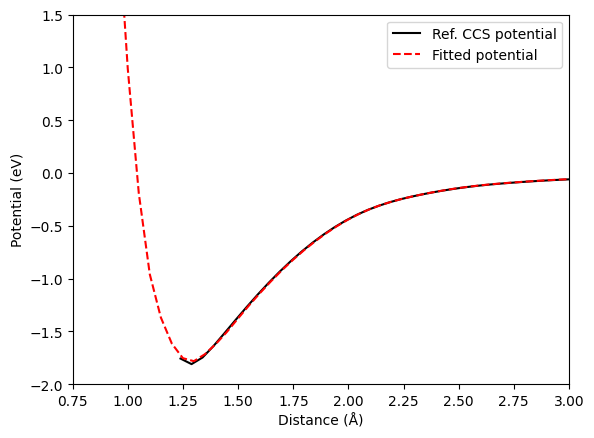

In [7]:
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params_reference.json", "r") as f:
    CCS_params_ref = json.load(f)

with open("CCS_params_pre_prune.json", "r") as f:
    CCS_params = json.load(f)

r_ref = np.array(CCS_params_ref["Two_body"]["O-O"]["r"])
e_ref = CCS_params_ref["Two_body"]["O-O"]["spl_a"]

r = np.array(CCS_params["Two_body"]["O-O"]["r"])
e = CCS_params["Two_body"]["O-O"]["spl_a"]

plt.xlim(0.75,3)
plt.ylim(-2,1.5)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r_ref,e_ref,color='black',label="Ref. CCS potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

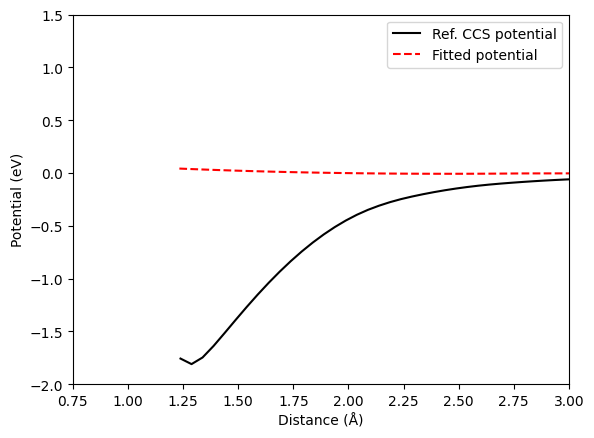

In [9]:
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params_reference.json", "r") as f:
    CCS_params_ref = json.load(f)

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

r_ref = np.array(CCS_params_ref["Two_body"]["O-O"]["r"])
e_ref = CCS_params_ref["Two_body"]["O-O"]["spl_a"]

r = np.array(CCS_params["Two_body"]["O-O"]["r"])
e = CCS_params["Two_body"]["O-O"]["spl_a"]

plt.xlim(0.75,3)
plt.ylim(-2,1.5)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r_ref,e_ref,color='black',label="Ref. CCS potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

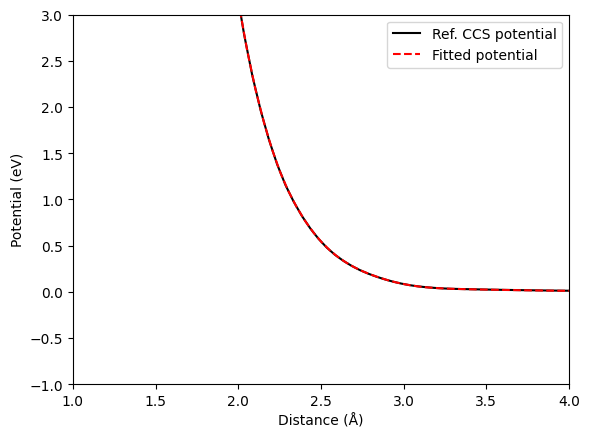

In [8]:
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params_reference.json", "r") as f:
    CCS_params_ref = json.load(f)

with open("CCS_params_pre_prune.json", "r") as f:
    CCS_params = json.load(f)

r_ref = np.array(CCS_params_ref["Two_body"]["Ti-O"]["r"])
e_ref = CCS_params_ref["Two_body"]["Ti-O"]["spl_a"]

r = np.array(CCS_params["Two_body"]["O-Ti"]["r"])
e = CCS_params["Two_body"]["O-Ti"]["spl_a"]

plt.xlim(1.,4)
plt.ylim(-1,3)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r_ref,e_ref,color='black',label="Ref. CCS potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

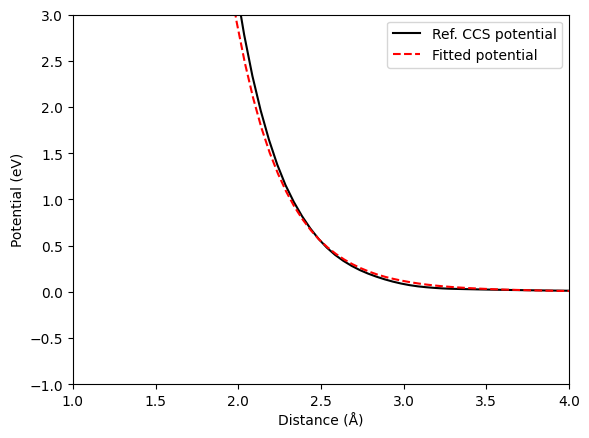

In [21]:
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params_reference.json", "r") as f:
    CCS_params_ref = json.load(f)

with open("CCS_params_pre_prune.json", "r") as f:
    CCS_params = json.load(f)

r_ref = np.array(CCS_params_ref["Two_body"]["Ti-O"]["r"])
e_ref = CCS_params_ref["Two_body"]["Ti-O"]["spl_a"]

r = np.array(CCS_params_ref["Two_body"]["Ca-O"]["r"])
e = CCS_params_ref["Two_body"]["Ca-O"]["spl_a"]

plt.xlim(1.,4)
plt.ylim(-1,3)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r_ref,e_ref,color='black',label="Ref. CCS potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

### Cleaning up

In [10]:
import glob
import os

def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass


list=glob.glob("CALCULATED_DATA/*")
for file in list:
    rm(file)
list=glob.glob("CCS_*")
for file in list:
    rm(file)
rm("structures.json")
rm("file_list")
rm("LJ.db")
rm("ccs.spl")
rm("Buckingham.dat")
rm("Lennard_Jones.dat")
rm("Morse.dat")